Epoch 001 | Loss: 12.9696 | Accuracy: 0.7294
Epoch 002 | Loss: 13.5585 | Accuracy: 0.7330
Epoch 003 | Loss: 14.0757 | Accuracy: 0.7294
Epoch 004 | Loss: 12.8118 | Accuracy: 0.7340
Epoch 005 | Loss: 12.5914 | Accuracy: 0.7304
Epoch 006 | Loss: 11.9020 | Accuracy: 0.7325
Epoch 007 | Loss: 12.1821 | Accuracy: 0.7325
Epoch 008 | Loss: 11.5636 | Accuracy: 0.7309
Epoch 009 | Loss: 12.0252 | Accuracy: 0.7263
Epoch 010 | Loss: 11.4670 | Accuracy: 0.7248
Epoch 011 | Loss: 10.3683 | Accuracy: 0.7360
Epoch 012 | Loss: 9.9706 | Accuracy: 0.7391
Epoch 013 | Loss: 9.9337 | Accuracy: 0.7375
Epoch 014 | Loss: 10.5263 | Accuracy: 0.7269
Epoch 015 | Loss: 9.6229 | Accuracy: 0.7335
Epoch 016 | Loss: 10.1451 | Accuracy: 0.7258
Epoch 017 | Loss: 9.8064 | Accuracy: 0.7274
Epoch 018 | Loss: 9.2065 | Accuracy: 0.7345
Epoch 019 | Loss: 9.3835 | Accuracy: 0.7314
Epoch 020 | Loss: 8.9242 | Accuracy: 0.7345
Epoch 021 | Loss: 8.8990 | Accuracy: 0.7350
Epoch 022 | Loss: 9.1632 | Accuracy: 0.7253
Epoch 023 | Loss: 8

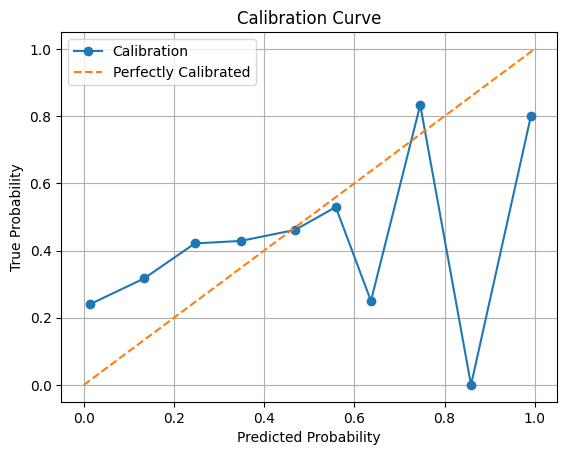

In [7]:
# ✅ Clean Baseline QoR Model with GCN + LSTM + Focal Loss + Patient-wise Evaluation

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.metrics import classification_report, brier_score_loss
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# 🔧 Config
WINDOW_SIZE = 120
STRIDE = 10
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4

# 📦 Load Data
path = r"D:\Data\NYC\KINZ\KINECT_dataset_with_qor15.csv"
df = pd.read_csv(path)
df = df[df['walking_speed'] == 'Fast']
df.dropna(subset=['QoR_class'], inplace=True)

# 🧱 Graph Structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'),
         ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] +
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# 📚 Dataset
class WindowedDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size, stride):
        self.samples = []
        grouped = df.groupby(['patient_id', 'trial'])
        for (pid, trial), group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq = torch.tensor([
                    [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                aux_seq = torch.tensor([
                    [row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']] 
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((x_seq, aux_seq, label, pid))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# 🔀 Split
train_ids, test_ids = train_test_split(df['patient_id'].unique(), test_size=0.3, random_state=42)
train_df = df[df['patient_id'].isin(train_ids)]
test_df = df[df['patient_id'].isin(test_ids)]

train_dataset = WindowedDataset(train_df, WINDOW_SIZE, STRIDE)
test_dataset = WindowedDataset(test_df, WINDOW_SIZE, STRIDE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 🧠 Model
class GCN_LSTM_Model(nn.Module):
    def __init__(self, in_channels=4, hidden_channels=128):
        super().__init__()
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.lstm = nn.LSTM(hidden_channels, hidden_channels, batch_first=True)
        self.aux_fc = nn.Linear(3, hidden_channels)
        self.classifier = nn.Linear(2 * hidden_channels, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, feat_dim = x_seq.shape
        x_seq = x_seq.view(B * T * N, feat_dim)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn(x_seq, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x, _ = self.lstm(x)
        aux = F.relu(self.aux_fc(aux_seq.mean(1)))
        return self.classifier(torch.cat([x[:, -1, :], aux], dim=-1)).view(-1)

# 🎯 Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE)
        return (self.alpha * (1 - pt) ** self.gamma * BCE).mean()

# 🚀 Training
model = GCN_LSTM_Model().to('cuda')
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y, _ in train_dataset:
        x_seq, aux_seq, y = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda'), y.unsqueeze(0).to('cuda')
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += 1
    print(f"Epoch {epoch+1:03d} | Loss: {total_loss/total:.4f} | Accuracy: {correct/total:.4f}")

# 📊 Per-Patient Evaluation
model.eval()
patient_results = defaultdict(list)
with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda')
        out = torch.sigmoid(model(x_seq, aux_seq)).cpu().item()
        patient_results[pid].append({'pred': int(out >= 0.5), 'true': int(y.item()), 'prob': out})

summary = []
for pid, recs in patient_results.items():
    preds = [r['pred'] for r in recs]
    trues = [r['true'] for r in recs]
    probs = [r['prob'] for r in recs]
    valid = sum(p == t for p, t in zip(preds, trues))
    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(100 * valid / len(trues), 2),
        'average_model_output': round(sum(probs)/len(probs), 4)
    })

report_df = pd.DataFrame(summary).sort_values('PatientID')
print(report_df)

# 📈 Calibration Curve
all_probs = []
all_labels = []
with torch.no_grad():
    for x_seq, aux_seq, y, _ in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda')
        prob = torch.sigmoid(model(x_seq, aux_seq)).cpu().item()
        all_probs.append(prob)
        all_labels.append(y.item())

prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# ✅ Advanced QoR Model with Multi-GCN + Transformer + Attention Fusion + Calibration

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# 🔧 Config
WINDOW_SIZE = 120
STRIDE = 10
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 1e-4

# 📦 Load Data
path = r"D:\Data\NYC\KINZ\KINECT_dataset_with_qor15.csv"
df = pd.read_csv(path)
df = df[df['walking_speed'] == 'Fast']
df.dropna(subset=['QoR_class'], inplace=True)

# 🧱 Graph Structure
joints = ['PELVIS', 'SPINE_NAVAL', 'SPINE_CHEST', 'NECK', 'CLAVICLE_LEFT', 'SHOULDER_LEFT',
          'ELBOW_LEFT', 'WRIST_LEFT', 'HAND_LEFT', 'HANDTIP_LEFT', 'THUMB_LEFT',
          'CLAVICLE_RIGHT', 'SHOULDER_RIGHT', 'ELBOW_RIGHT', 'WRIST_RIGHT', 'HAND_RIGHT',
          'HANDTIP_RIGHT', 'THUMB_RIGHT', 'HIP_LEFT', 'KNEE_LEFT', 'ANKLE_LEFT',
          'FOOT_LEFT', 'HIP_RIGHT', 'KNEE_RIGHT', 'ANKLE_RIGHT', 'FOOT_RIGHT',
          'HEAD', 'NOSE', 'EYE_LEFT', 'EAR_LEFT', 'EYE_RIGHT', 'EAR_RIGHT']

edges = [('PELVIS', 'SPINE_NAVAL'), ('SPINE_NAVAL', 'SPINE_CHEST'), ('SPINE_CHEST', 'NECK'),
         ('NECK', 'HEAD'), ('SPINE_CHEST', 'CLAVICLE_LEFT'), ('CLAVICLE_LEFT', 'SHOULDER_LEFT'),
         ('SHOULDER_LEFT', 'ELBOW_LEFT'), ('ELBOW_LEFT', 'WRIST_LEFT'), ('WRIST_LEFT', 'HAND_LEFT'),
         ('HAND_LEFT', 'HANDTIP_LEFT'), ('WRIST_LEFT', 'THUMB_LEFT'), ('SPINE_CHEST', 'CLAVICLE_RIGHT'),
         ('CLAVICLE_RIGHT', 'SHOULDER_RIGHT'), ('SHOULDER_RIGHT', 'ELBOW_RIGHT'), ('ELBOW_RIGHT', 'WRIST_RIGHT'),
         ('WRIST_RIGHT', 'HAND_RIGHT'), ('HAND_RIGHT', 'HANDTIP_RIGHT'), ('WRIST_RIGHT', 'THUMB_RIGHT'),
         ('PELVIS', 'HIP_LEFT'), ('HIP_LEFT', 'KNEE_LEFT'), ('KNEE_LEFT', 'ANKLE_LEFT'),
         ('ANKLE_LEFT', 'FOOT_LEFT'), ('PELVIS', 'HIP_RIGHT'), ('HIP_RIGHT', 'KNEE_RIGHT'),
         ('KNEE_RIGHT', 'ANKLE_RIGHT'), ('ANKLE_RIGHT', 'FOOT_RIGHT'),
         ('HEAD', 'NOSE'), ('HEAD', 'EYE_LEFT'), ('HEAD', 'EYE_RIGHT'),
         ('HEAD', 'EAR_LEFT'), ('HEAD', 'EAR_RIGHT')]

joint_to_idx = {j: i for i, j in enumerate(joints)}
edge_index = torch.tensor([[joint_to_idx[a], joint_to_idx[b]] for a, b in edges] +
                          [[joint_to_idx[b], joint_to_idx[a]] for a, b in edges], dtype=torch.long).t()

# 📚 Dataset
class WindowedDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size, stride):
        self.samples = []
        grouped = df.groupby(['patient_id', 'trial'])
        for (pid, trial), group in grouped:
            group = group.sort_values('t_uniform')
            if len(group) < window_size:
                continue
            for i in range(0, len(group) - window_size + 1, stride):
                window = group.iloc[i:i+window_size]
                x_seq = torch.tensor([
                    [[row[f'{j}_X'], row[f'{j}_Y'], row[f'{j}_Z'], row['t_uniform']] for j in joints]
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                aux_seq = torch.tensor([
                    [row['left_foot_swing'], row['right_foot_swing'], row['pelvis_pos']]
                    for _, row in window.iterrows()
                ], dtype=torch.float)
                label = torch.tensor(window['QoR_class'].mode().values[0], dtype=torch.float)
                self.samples.append((x_seq, aux_seq, label, pid))

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]

# 🔀 Split
train_ids, test_ids = train_test_split(df['patient_id'].unique(), test_size=0.3, random_state=42)
train_df = df[df['patient_id'].isin(train_ids)]
test_df = df[df['patient_id'].isin(test_ids)]
train_dataset = WindowedDataset(train_df, WINDOW_SIZE, STRIDE)
test_dataset = WindowedDataset(test_df, WINDOW_SIZE, STRIDE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 🔠 Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x): return x + self.pe[:, :x.size(1)]

# 🧠 Model
class GCNTransformerModel(nn.Module):
    def __init__(self, in_channels=4, gcn_hidden=64, transformer_hidden=128):
        super().__init__()
        self.gcn1 = GCNConv(in_channels, gcn_hidden)
        self.gcn2 = GCNConv(gcn_hidden, gcn_hidden)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=gcn_hidden, nhead=4, dim_feedforward=256), num_layers=2)
        self.pos_encoder = PositionalEncoding(gcn_hidden)
        self.aux_fc = nn.Sequential(
            nn.Linear(3, 64), nn.ReLU(),
            nn.Linear(64, transformer_hidden), nn.ReLU()
        )
        self.classifier = nn.Linear(transformer_hidden + gcn_hidden, 1)

    def forward(self, x_seq, aux_seq):
        B, T, N, F = x_seq.shape
        x_seq = x_seq.view(B * T * N, F)
        full_edge_index = torch.cat([edge_index + b * N for b in range(B * T)], dim=1).to(x_seq.device)
        x = F.relu(self.gcn1(x_seq, full_edge_index))
        x = F.relu(self.gcn2(x, full_edge_index))
        x = x.view(B, T, N, -1).mean(2)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x[:, -1, :]  # last token
        aux = self.aux_fc(aux_seq.mean(1))
        return self.classifier(torch.cat([x, aux], dim=-1)).view(-1)

# 🎯 Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        BCE = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE)
        return (self.alpha * (1 - pt) ** self.gamma * BCE).mean()

# 🚀 Training
model = GCNTransformerModel().to('cuda')
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x_seq, aux_seq, y, _ in train_dataset:
        x_seq, aux_seq, y = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda'), y.unsqueeze(0).to('cuda')
        optimizer.zero_grad()
        out = model(x_seq, aux_seq)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += ((torch.sigmoid(out) >= 0.5).float() == y).sum().item()
        total += 1
    print(f"Epoch {epoch+1:03d} | Loss: {total_loss/total:.4f} | Accuracy: {correct/total:.4f}")

# 📊 Evaluation
model.eval()
patient_results = defaultdict(list)
with torch.no_grad():
    for x_seq, aux_seq, y, pid in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda')
        out = torch.sigmoid(model(x_seq, aux_seq)).cpu().item()
        patient_results[pid].append({'pred': int(out >= 0.5), 'true': int(y.item()), 'prob': out})

summary = []
for pid, recs in patient_results.items():
    preds = [r['pred'] for r in recs]
    trues = [r['true'] for r in recs]
    probs = [r['prob'] for r in recs]
    valid = sum(p == t for p, t in zip(preds, trues))
    summary.append({
        'PatientID': pid,
        'Predicted_QoR_class': max(set(preds), key=preds.count),
        'Actual_QoR_class': max(set(trues), key=trues.count),
        'valid_percentage': round(100 * valid / len(trues), 2),
        'average_model_output': round(sum(probs)/len(probs), 4)
    })
report_df = pd.DataFrame(summary).sort_values('PatientID')
print(report_df)

# 📈 Calibration Curve
all_probs, all_labels = [], []
with torch.no_grad():
    for x_seq, aux_seq, y, _ in test_dataset:
        x_seq, aux_seq = x_seq.unsqueeze(0).to('cuda'), aux_seq.unsqueeze(0).to('cuda')
        prob = torch.sigmoid(model(x_seq, aux_seq)).cpu().item()
        all_probs.append(prob)
        all_labels.append(y.item())

prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.grid(True)
plt.legend()
plt.show()


c:\Users\user\miniconda3\envs\torch_on\lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


AttributeError: 'int' object has no attribute 'relu'